In [75]:
import json
import pathlib

import cv2
import numpy as np
import matplotlib.pyplot as plt

from statistics import mode

from src import video, feed
from src.display import showarray
from src.processing import ImageMatcher, Homographer, BoardMapper
from src.processing import analyzers, detectors, features, calc
from src.monopoly.elements import FieldIndex, deserialize_families, deserialize_fields

In [9]:
board_image = cv2.imread("data/images/board.jpg")

In [10]:
CARD_RATIO = 8.5 / 5.5

def filter_contours(contours: list[np.ndarray]) -> list[np.ndarray]:
    
    return [
        contour 
        for contour in contours
        if calc.is_min_area_in_bounds_and_good_edges_ratio(contour, 10_000, 25_000, CARD_RATIO)
    ]

In [11]:
class RectDrawingAnalyzer(analyzers.Analyzer):
    def __init__(self, names: list[str], colors: list[tuple[int, int, int]], type_list: list[bool]) -> None:
        self.names = names
        self.colors = colors
        self.type_list = type_list
        self.rects = []
        
    def analyze_raw(self, frame: np.ndarray, **kwargs) -> None:
        for name, color, type_ in zip(self.names, self.colors, self.type_list):
            self.rects.append(kwargs.get(name))

    def mutate_frame(self, frame: np.ndarray) -> np.ndarray:
        for color, _type, rect in zip(self.colors, self.type_list, self.rects):
            if rect is not None:
                if _type:
                    frame = cv2.rectangle(frame, rect, color, 2)
                else:
                    frame = cv2.polylines(frame, [np.int32(rect)], True, color, 2)
        return frame

In [12]:
class ContextHistorySaver:
    def __init__(self):
        self.history = {}

    def __call__(self, context: dict) -> None:
        for key in context:
            if key not in self.history:
                self.history[key] = []
            self.history[key].append(context[key])


context_history_saver = ContextHistorySaver()

In [13]:
rect_analyzer = RectDrawingAnalyzer(
    names=["board_points", "dice_area_rect"],
    colors=[(255, 255, 0), (0, 255, 255)],
    type_list=[False, True]
)

white_piece_analyzer = analyzers.WhitePieceAnalyzer(piece_detector=detectors.get_white_piece_detector(), threaded=True)
black_piece_analyzer = analyzers.BlackPieceAnalyzer(threaded=True)

dots_analyzer = analyzers.DotsAnalyzer(blob_detector=detectors.get_dots_detector(), threaded=True)
cards_analyzer = analyzers.CardsAnalyzer(
    edge_detector=features.get_threshold_edges,
    contour_filter=filter_contours,
    threaded=True
)

live_feed = feed.LiveFrameProcessor("feed", 800, 400)

used_analyzers = [rect_analyzer, white_piece_analyzer, black_piece_analyzer, dots_analyzer, cards_analyzer]

In [14]:
with video.VideoHandler("data/recordings/Easy_2.mp4") as vh:
    first_frame = vh.get_frame(0)
    image_matcher = ImageMatcher(first_frame, board_image)
    matches = image_matcher.get_matches()
    homographer = Homographer(image_matcher.kp_ref, image_matcher.kp_match, matches)
    homography, _ = homographer.get_inverse_homography()
    dst_rect = features.get_board_min_rect_from_homography(homography, board_image)
    additonal_context = dict(board_points=cv2.boxPoints(dst_rect), dice_area_rect=features.find_dice_throwing_rect(first_frame))
    vh.go_through_video(live_feed, used_analyzers, additional_context=additonal_context, context_processor=context_history_saver)

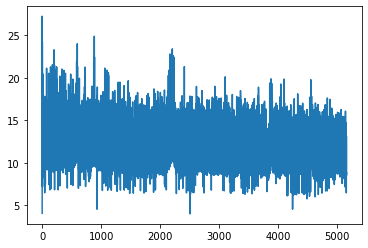

In [17]:
plt.plot(context_history_saver.history["fps"])
plt.show()

In [62]:
board_mapper = BoardMapper(homographer.get_homography()[0], max(board_image.shape))
serialized_families = json.loads(pathlib.Path("data/meta/families.json").read_text())
serialized_fields = json.loads(pathlib.Path("data/meta/fields.json").read_text())

families = {family.name: family for family in deserialize_families(serialized_families)}
fields = list(deserialize_fields(serialized_fields, families))
field_index = FieldIndex(fields)

In [60]:
board_mapper.map_point_to_field_position(*context_history_saver.history["black_pos"][20])


('bottom', 5)

In [73]:
def decode_positions(field_index: FieldIndex, positions: list[tuple[int, int] | None], board_mapper: BoardMapper):
    decoded_positions = []
    for position in positions:
        decoded_position = None
        if position is not None:
            section, index = board_mapper.map_point_to_field_position(*position)
            if section not in ["inside", "outside"]:
                field = field_index.get_by_place(section, index)
                if field is not None:
                    decoded_position = field.id
        if decoded_position is None:
            if len(decoded_positions) == 0:
                continue
            else:
                decoded_position = decoded_positions[-1]
        decoded_positions.append(decoded_position)
    return decoded_positions

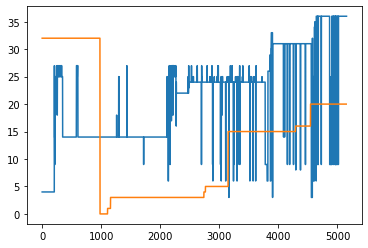

In [74]:
black_decoded = decode_positions(field_index, context_history_saver.history["black_pos"], board_mapper)
white_decoded = decode_positions(field_index, context_history_saver.history["white_pos"], board_mapper)

plt.plot(black_decoded)
plt.plot(white_decoded)
plt.show()

In [106]:
def denoise_series_middle(series: list[int], window_size: int = 5) -> list[int]:
    return [mode(series[i - window_size:i + window_size]) for i in range(window_size, len(series) - window_size)]

def denoise_series_left(series: list[int], window_size: int = 5) -> list[int]:
    return [mode(series[i - window_size:i]) for i in range(window_size, len(series) - window_size)]

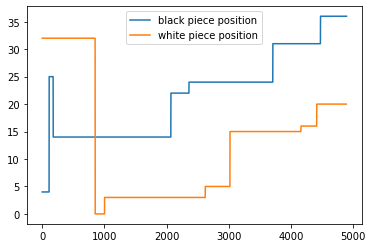

In [107]:
denoised_black = denoise_series_middle(black_decoded, window_size=130)
denoised_white = denoise_series_middle(white_decoded, window_size=130)

plt.plot(denoised_black, label="black piece position")
plt.plot(denoised_white, label="white piece position")
plt.legend()
plt.show()

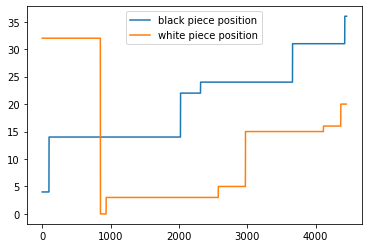

In [119]:
denoised_black = denoise_series_left(black_decoded, window_size=350)
denoised_white = denoise_series_left(white_decoded, window_size=350)

plt.plot(denoised_black, label="black piece position")
plt.plot(denoised_white, label="white piece position")
plt.legend()
plt.show()

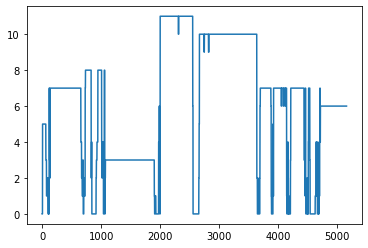

In [100]:
dice_result = [len(points) for points in context_history_saver.history["dice_dots"]]
plt.plot(dice_result)
plt.show()

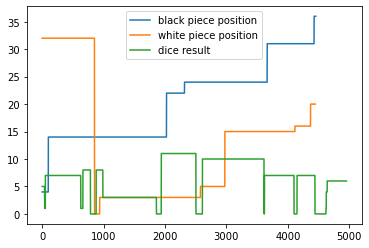

In [120]:
plt.plot(denoised_black, label="black piece position")
plt.plot(denoised_white, label="white piece position")
plt.plot(denoise_series_left(dice_result, window_size=100), label="dice result")
plt.legend()
plt.show()

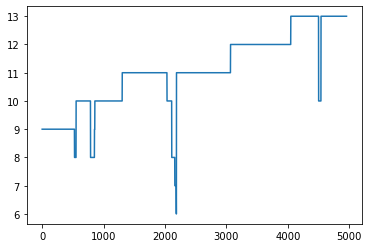

In [127]:
cards_count = context_history_saver.history["cards"]
denoised_cards_count = denoise_series_left(cards_count, window_size=100)
plt.plot(denoised_cards_count, label="cards count")

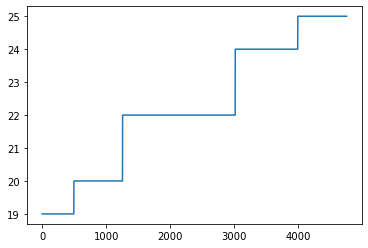

In [134]:
card_dots = [len(points) for points in context_history_saver.history["card_dots"]]
denoised_card_dots = denoise_series_left(card_dots, window_size=200)
plt.plot(denoised_card_dots, label="card dots")
plt.show()